In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from models import *
from utils import *

import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter, OrderedDict
import cv2
from PIL import Image
from IPython.display import clear_output
from sort import *

In [44]:
import track_tools as tt
clear_output()

In [4]:
mpl.rcParams.update({'font.size': 14})
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

In [5]:
MODE = 'load'
PATH = '20190612_175832.slow.pkl' # 'tmp.pkl'
MAX_FRAMES = np.Inf
FPS = 30/8
DISPLAY = 0
DATA = Path(r'D:\Media\Videos\Ayalon')
# videopath = str(DATA/'20190622_124116.mp4') # bad detection
# videopath = str(DATA/'20190703_163050_slipping_protest.2.mp4') # fast
videopath = str(DATA/'20190612_175832.mp4') # slow

# Set YOLO model and detection function

In [6]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

In [7]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

# Apply trackings

In [8]:
if MODE == 'load':
    
    with open(PATH,'rb') as f:
        dct = pkl.load(f)
    X = dct['X']
    Y = dct['Y']
    S = dct['S']
    C = dct['C']
    H,W = dct['size']
    
else:

    %pylab inline

    # initialize Sort object and video capture
    vid = cv2.VideoCapture(videopath)
    n_frames = int(np.min((vid.get(cv2.CAP_PROP_FRAME_COUNT),MAX_FRAMES)))
    mot_tracker = Sort() 
    X = pd.DataFrame(index=list(range(n_frames)))
    Y = pd.DataFrame(index=list(range(n_frames)))
    S = pd.DataFrame(index=list(range(n_frames)))
    C = pd.DataFrame(index=list(range(n_frames)))
    other_objs = []

    T0 = time.time()
    for ii in tnrange(n_frames):
        ret, frame = vid.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)[-350:-50,:650,:] # [-450:-50,:950,:]
        pilimg = Image.fromarray(frame)
        detections = detect_image(pilimg)

        img = np.array(pilimg)
        pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
        pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
        unpad_h = img_size - pad_y
        unpad_w = img_size - pad_x
        if detections is not None:
            tracked_objects = mot_tracker.update(detections.cpu())

            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
            for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
                box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
                box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
                y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
                x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

                if cls_pred in (2,3,5,6,7): # vehicles
                    col_nm = f'{obj_id:.0f}'
                    if col_nm not in X.columns:
                        X[col_nm] = None
                        Y[col_nm] = None
                        S[col_nm] = None
                        C[col_nm] = None
                    X.loc[ii,col_nm] = img.shape[1]-(x1+box_w/2)
                    Y.loc[ii,col_nm] = y1+box_h/2
                    S.loc[ii,col_nm] = np.sqrt(box_w**2+box_h**2)
                    C.loc[ii,col_nm] = classes[int(cls_pred)]
                else:
                    other_objs.append((ii, x1, y1, x2, y2, obj_id, cls_pred))

                color = colors[int(obj_id) % len(colors)]
                color = [i * 255 for i in color]
                cls = classes[int(cls_pred)]
                cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
                cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
                cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

        if DISPLAY:
            fig=figure(figsize=(12, 8))
            title(f"Frame {ii+1:d}/{n_frames:d} ({100*(ii+1)/n_frames:.0f}%)")
            imshow(frame)
            show()
            clear_output(wait=True)

    print(f'Elapsed time:\t{(time.time()-T0)/60:.1f} [min]')
    fig=figure(figsize=(12, 8))
    title(f"Frame {ii+1:d}/{n_frames:d} ({100*(ii+1)/n_frames:.0f}%)")
    imshow(frame)
    show()
    clear_output(wait=True)

In [11]:
# Summarize cars tracking
df = pd.DataFrame(index=X.columns)
df['class'] = [C.loc[C[car].notnull(),car].values[0] if len(Counter(C.loc[C[car].notnull(),car]))==1
               else str(Counter(C.loc[C[car].notnull(),car])) for car in C.columns]
[int(C[car][0]) if len(Counter(C[car].notnull()))==1 else str(Counter(C[car].notnull())) for car in X.columns]
df['n_shots'] = [X[car].notnull().sum() for car in X.columns]
df['consistent_class'] = [not c.startswith('Counter') for c in df['class']]
df['consistent_xy_nas'] = [np.logical_not(np.logical_xor(X[car].notnull(),Y[car].notnull())).all() for car in X.columns]
df['continuous_track'] = [np.all(np.diff(np.where(X[car].notnull()))==1) for car in X.columns]
df['avg_size'] = S.mean() # diameter [pixels]
df['max_size'] = S.max()
df['valid_size'] = df['max_size'] < 4 * df['avg_size'].median()
df['neg_x_motion'] = [X.loc[X[car].notnull(),car].diff()[1:].clip(None,0).abs().sum() /\
                      X.loc[X[car].notnull(),car].diff()[1:].abs().sum()
                      if X.loc[X[car].notnull(),car].diff()[1:].abs().sum()>0 else 0
                      for car in X.columns]
df['neg_y_motion'] = [Y.loc[Y[car].notnull(),car].diff()[1:].clip(None,0).abs().sum() /\
                      Y.loc[Y[car].notnull(),car].diff()[1:].abs().sum()
                      if Y.loc[Y[car].notnull(),car].diff()[1:].abs().sum()>0 else 0
                      for car in Y.columns]
df['valid_x_dir'] = df['neg_x_motion'] < 0.04
df['valid_y_dir'] = df['neg_y_motion'] < 0.04
df['min_x'] = X.min()
df['max_x'] = X.max()
df['min_y'] = Y.min()
df['max_y'] = Y.max()
df['t0'] = [X.index[np.where(X[car].notnull())[0][0]]/FPS for car in X.columns]
df['dt'] = [(X.index[np.where(X[car].notnull())[0][-1]]-X.index[np.where(X[car].notnull())[0][0]])/FPS for car in X.columns]
df['dx'] = df.max_x - df.min_x
df['dy'] = df.max_y - df.min_y
df['x_path_rel'] = df.dx/W
df['y_path_rel'] = df.dy/H
df['long_path'] = df['x_path_rel'] > 0.3
df['v'] = np.sqrt(df.dx.pow(2)+df.dy.pow(2))/df.dt # [pixels / sec]
df['abs_v'] = [np.sum( np.power( np.power(np.diff(X[car][X[car].notnull()]),2) +
                                np.power(np.diff(Y[car][Y[car].notnull()]),2), 0.5 ) ) /
               (X.index[X[car].notnull()][-1]-X.index[X[car].notnull()][0]) * FPS
               for car in X.columns]
slope = np.median((df.dy/df.dx).dropna())
df['road_perpendicularity'] = [np.median( ((Y[car]-slope*X[car]) / np.sqrt((1+slope**2))).dropna() ) for car in X.columns]
df['perpendicular_range'] = [np.ptp( ((Y[car]-slope*X[car]) / np.sqrt((1+slope**2))).dropna() ) for car in X.columns]

print(df.shape)
df.head()

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in longlong_scalars


(1410, 27)


,class,n_shots,consistent_class,consistent_xy_nas,continuous_track,avg_size,max_size,valid_size,neg_x_motion,neg_y_motion,...,dt,dx,dy,x_path_rel,y_path_rel,long_path,v,abs_v,road_perpendicularity,perpendicular_range
12,truck,8,True,True,False,102.162959,108.226614,True,0.0,0.000000,...,2.133333,108.5,27.0,0.166923,0.090000,False,52.410464,52.604975,36.074527,8.544228
11,car,40,True,True,True,58.064291,61.911227,True,0.0,0.019417,...,10.400000,337.0,99.0,0.518462,0.330000,True,33.773140,34.461132,27.207700,9.373706
10,car,3,True,True,True,65.790297,67.601775,True,0.0,0.000000,...,0.533333,25.0,10.0,0.038462,0.033333,False,50.485920,50.831730,68.545011,2.631716
9,car,11,True,True,False,55.986974,57.801384,True,0.0,0.000000,...,2.933333,20.5,9.0,0.031538,0.030000,False,7.632482,8.105283,-8.663773,3.284250
8,car,1,True,True,True,62.649820,62.649820,True,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,False,NaN,NaN,56.154629,0.000000


In [ ]:
if MODE == 'save':
    with open(PATH,'wb') as f:
        pkl.dump({'X':X, 'Y':Y, 'S':S, 'C':C, 'size':img.shape[:2], 'others':other_objs, 'df':df}, f)

In [12]:
gc.collect()

126

# Post analysis

In [14]:
import seaborn as sns
mpl.rcParams.update({'font.size': 13})

In [15]:
def ordered_counter(tokens):
    return OrderedDict(sorted(Counter([tok for grp in tokens for tok in grp]).items(),
                              key=lambda kv: kv[1], reverse=1))


def qplot(x, ax=None, ylab='', logscale=False, assume_sorted=False):
    if ax is None:
        ax = plt.gca()
    n_orig = len(x)
    try:
        x = x[x.notnull()]
    except:
        x = x[np.logical_not(np.isnan(x))]
    if not assume_sorted:
        x = sorted(x)
    
    ax.axhline(np.mean(x), linestyle=':', color='blue', label='Average')
    ax.plot(list(range(101)), [x[int(q/100*(len(x)-1))] for q in range(101)], 'k.-')
    ax.set_xlabel('Quantile [%]')
    ax.set_ylabel(ylab)
    ax.set_xlim((0,100))
    ax.set_title(f'Valid values: {len(x):d}/{n_orig:d} ({100*len(x)/n_orig:.1f}%)')
    if logscale:
        ax.set_yscale('log')
    ax.grid()
    ax.legend()

def qplots(X, ax=None, logscale=False, assume_sorted=False):
    if ax is None:
        ax = plt.gca()
    
    n_orig = X.shape[0]
    X = X[X.notnull().all(axis=1)]
    
    for c in X.columns:
        x = X[c]
        if not assume_sorted:
            x = sorted(x)
        color = colors[int(np.random.rand()*len(colors))]
        ax.axhline(np.mean(x), linestyle=':', color=color)
        ax.plot(list(range(101)), [x[int(q/100*(len(x)-1))] for q in range(101)], '.-', color=color, label=c)
    ax.set_xlabel('Quantile [%]')
    ax.set_xlim((0,100))
    ax.set_title(f'Valid values: {len(X):d}/{n_orig:d} ({100*len(X)/n_orig:.1f}%)')
    if logscale:
        ax.set_yscale('log')
    ax.grid()
    ax.legend()

    
def boxplot_per_bucket(x, y, n_buckets=5, ax=None, xlab='', ylab='', numeric_x_ticks=False, logscale=False, assume_sorted=False):
    if ax is None:
        ax = plt.gca()
    
    n_orig = len(x)
    ids = np.logical_not(np.logical_or(np.isnan(x),np.isnan(y)))
    x = x[ids]
    y = y[ids]
        
    if not assume_sorted:
        x, y = zip(*sorted(zip(x, y)))
        
    quants = (len(x) * np.arange(0, 1+1e-6, 1/n_buckets)).astype(int)
    data_dict = {f'{str(x[q1])[:4]:s} - {str(x[q2-1])[:4]:s}': y[q1:q2] for q1,q2 in zip(quants[:-1],quants[1:])}
    labels, data = [*zip(*data_dict.items())]
    positions = [np.mean(x[q1:q2]) for q1,q2 in zip(quants[:-1],quants[1:])] if numeric_x_ticks else list(range(1,len(labels)+1))
    
    ax.boxplot(data, positions=positions, showmeans=True)
    ax.set_xticklabels(labels)
    ax.set_xticks(positions)
    ax.tick_params(axis='x', rotation=45)
    
    ax.axhline(np.mean(y), linestyle=':', color='blue', label='Average')
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(f'Valid values: {len(x):d}/{n_orig:d} ({100*len(x)/n_orig:.1f}%)')
    if logscale:
        ax.set_yscale('log')
    ax.grid()
    ax.legend()


def plot_track(X, Y, car, ax=None):
    if ax is None:
        ax = plt.gca()
    t0 = np.where(X[car].notnull())[0][0]
    ax.plot(X.loc[t0,car], Y.loc[t0,car], 's', color=colors[int(car) % len(colors)])
    ax.plot(X.loc[:,car],  Y.loc[:,car], '.-', color=colors[int(car) % len(colors)], label=car)

def set_track_figure(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xlim((W,0))
    ax.set_ylim((H,0))
    ax.grid()

#### Show all track

Wall time: 4.4 s


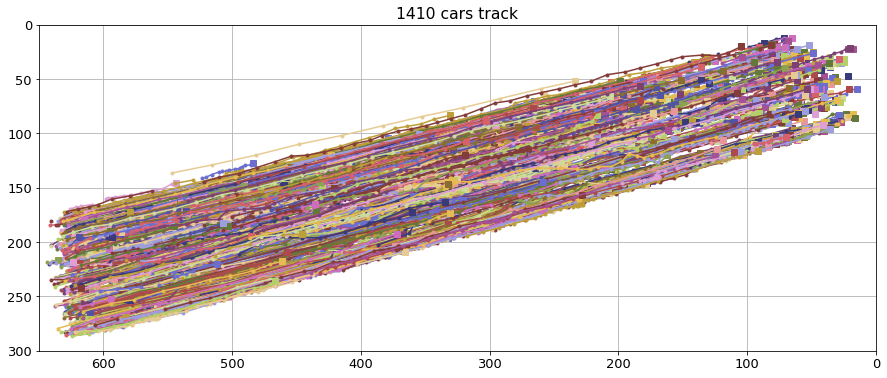

In [35]:
%%time

plt.figure(figsize=(15,6))
plt.title(f'{X.shape[1]:d} cars track')
tt.set_track_figure(W,H)

for car in X.columns:
    tt.plot_track(X,Y,car)

#### Show distributions of df's columns

In [17]:
variables_groups_to_compare = (
    ('consistent_class','consistent_xy_nas','valid_size','valid_x_dir','valid_y_dir'),
    ('continuous_track','long_path'),
    ('avg_size','max_size'),
    ('min_x','max_x'),
    ('min_y','max_y'),
    ('v','abs_v')
)

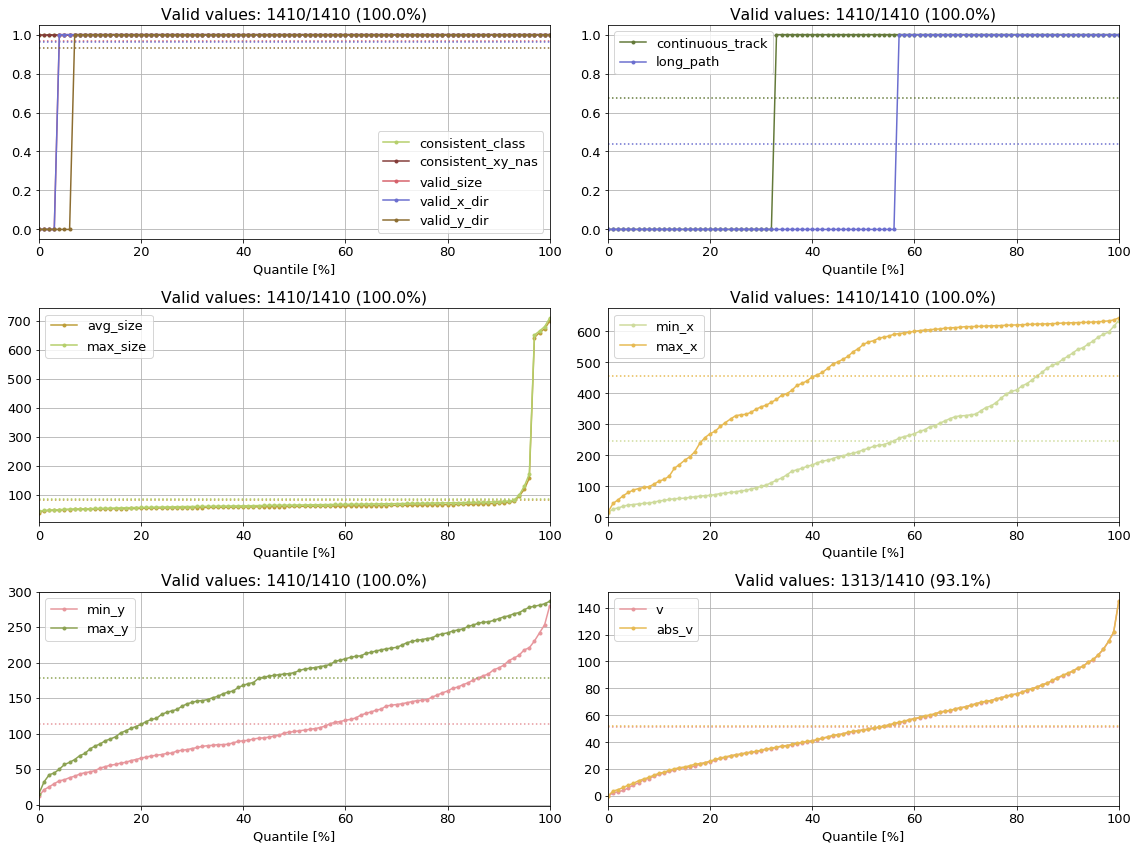

In [18]:
n_rows = int(np.ceil(5/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*4))

for i, cols in enumerate(variables_groups_to_compare):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.qplots(df.loc[:,cols])

plt.tight_layout()

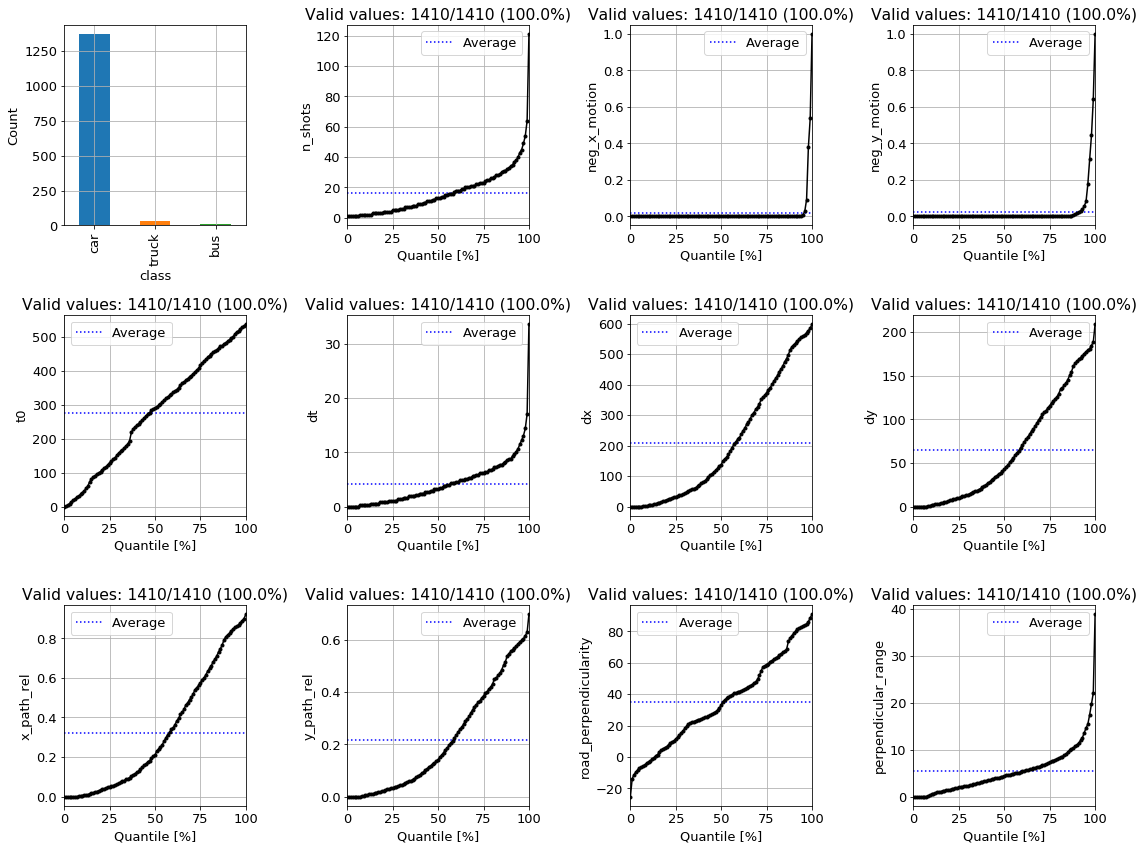

In [19]:
cols = [col for col in df.columns if not col in [c for grp in variables_groups_to_compare for c in grp]]
n_rows = int(np.ceil(len(cols)/4))
_, axs = plt.subplots(n_rows, 4, figsize=(16,n_rows*4))

for i,c in enumerate(cols):
    ax = plt.subplot(n_rows, 4, i+1)
    if type(df[c][0]) is str:
        df[c].value_counts().plot('bar')
        ax.set_xlabel(c)
        ax.set_ylabel('Count')
        ax.grid()
    else:
        tt.qplot(df[c], ax=ax, ylab=c, logscale=False)

plt.tight_layout()

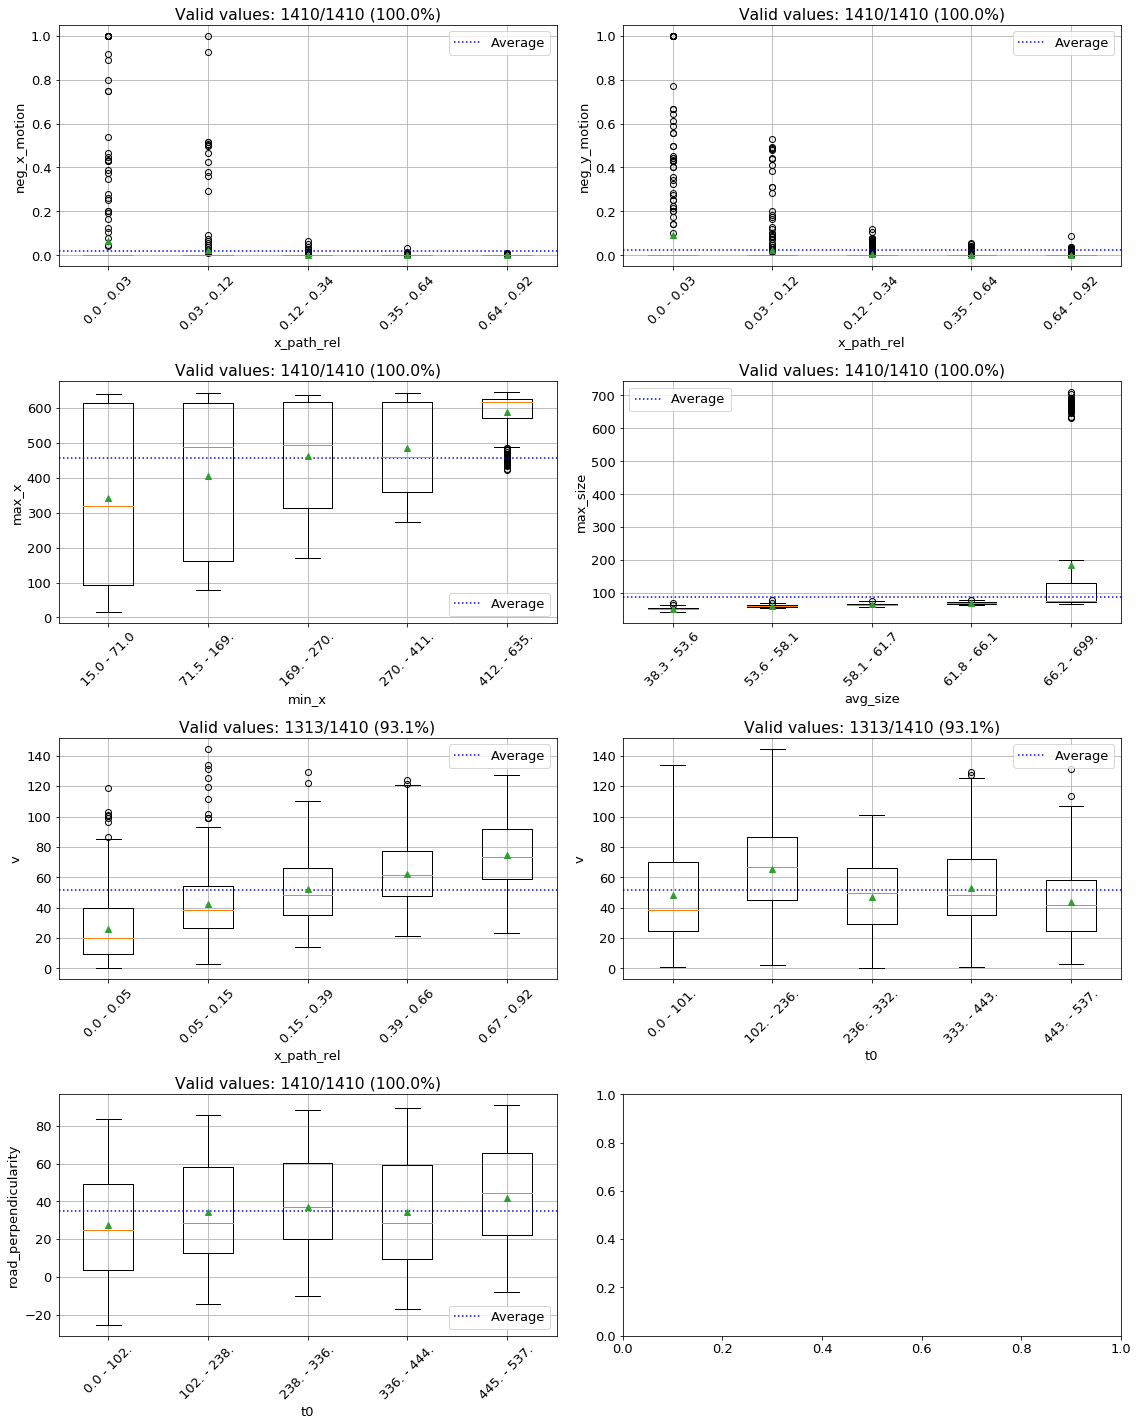

In [20]:
pairs = (
    ('x_path_rel','neg_x_motion'),
    ('x_path_rel','neg_y_motion'),
    ('min_x','max_x'),
    ('avg_size','max_size'),
    ('x_path_rel','v'),
    ('t0','v'),
    ('t0','road_perpendicularity'),
)

n_rows = int(np.ceil(len(pairs)/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*5))

for i,(c1,c2) in enumerate(pairs):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.boxplot_per_bucket(df[c1], df[c2], ax=ax, xlab=c1, ylab=c2, logscale=False)

plt.tight_layout()

#### Show invalid tracks

Valid fields:  consistent_class, consistent_xy_nas

valid_x_dir overlaps (all=53):
{'valid_y_dir': 43, 'valid_size': 33, 'long_path': 53, 'continuous_track': 24}

valid_y_dir overlaps (all=96):
{'valid_x_dir': 43, 'valid_size': 33, 'long_path': 88, 'continuous_track': 49}

valid_size overlaps (all=48):
{'valid_x_dir': 33, 'valid_y_dir': 33, 'long_path': 48, 'continuous_track': 17}

long_path overlaps (all=790):
{'valid_x_dir': 53, 'valid_y_dir': 88, 'valid_size': 48, 'continuous_track': 208}

continuous_track overlaps (all=460):
{'valid_x_dir': 24, 'valid_y_dir': 49, 'valid_size': 17, 'long_path': 208}


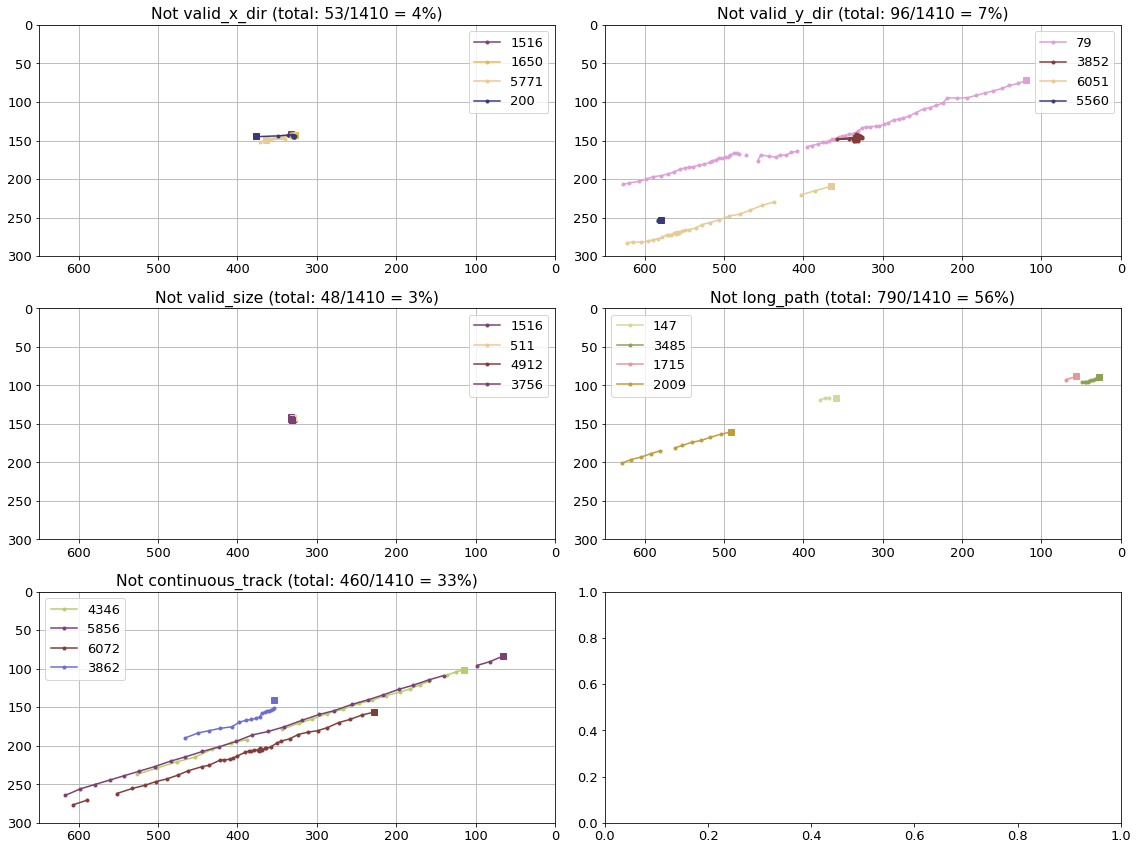

In [47]:
validations = ('consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir','valid_size','long_path','continuous_track')
n_samples = 4

all_valid = [val for val in validations if df[val].all()]
print('Valid fields: ', ', '.join(all_valid))

validations = [val for val in validations if val not in all_valid]
n_rows = int(np.ceil(len(validations)/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*4))

for i,val in enumerate(validations):
    ax = plt.subplot(n_rows, 2, i+1)
    tt.set_track_figure(W,H,ax)
    
    cars = df.index[np.logical_not(df[val])]
    n_bad = len(cars)
    if n_samples < len(cars):
        cars = np.random.choice(cars, n_samples, replace=False)
    
    for car in cars:
        tt.plot_track(X,Y,car,ax)
    ax.set_title(f'Not {val:s} (total: {n_bad:d}/{df.shape[0]:d} = {100*n_bad/df.shape[0]:.0f}%)')
    ax.legend()
    
    print(f'\n{val:s} overlaps (all={np.sum(np.logical_not(df[val])):d}):')
    print({val2: np.sum(np.logical_not(df.loc[np.logical_not(df[val]),val2])) for val2 in validations if val2!=val})

plt.tight_layout()

In [56]:
tt.record_video(videopath, X, Y, '79', self_track=8, display=False, to_save='neg_y')

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


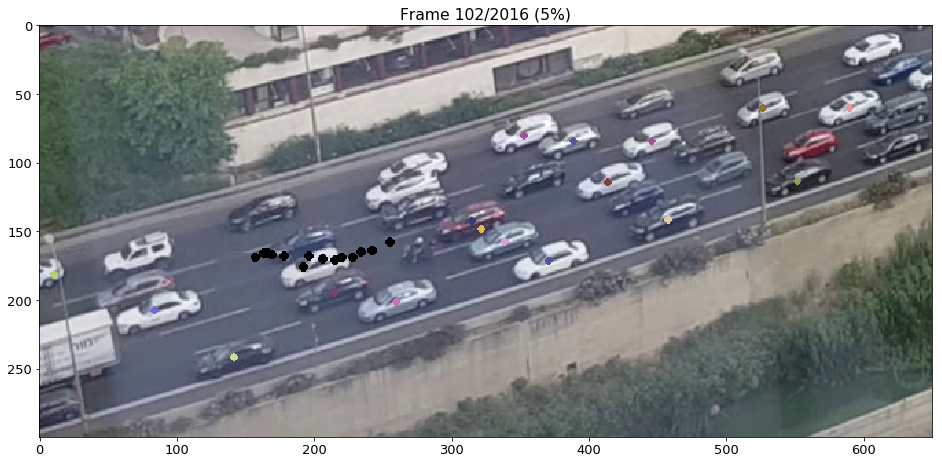

In [58]:
tt.record_frame(videopath, X, Y, '79', frm=52+50, self_track=8, display=True, to_save='neg_y')

Motion perpendicular to road:

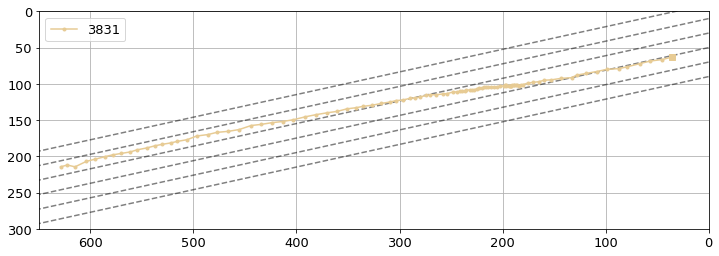

In [39]:
plt.figure(figsize=(12,4))

for i in range(-10,91,20):
    plt.plot(np.linspace(0, W, 100), slope*np.linspace(0, W, 100) + i, 'k--', alpha=0.5)

tt.set_track_figure(W,H)
car = np.random.choice(df.index[df.perpendicular_range>30])
tt.plot_track(X,Y,car)
plt.legend()

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


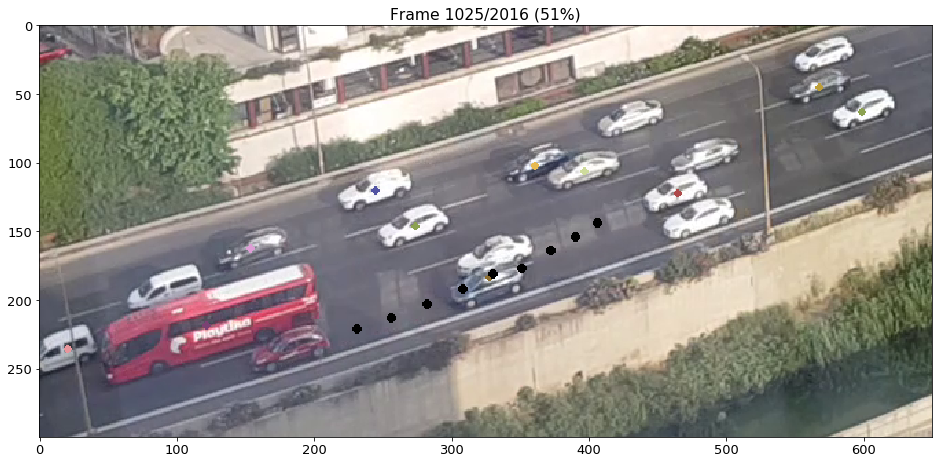

In [45]:
tt.record_frame(videopath, X, Y, '3647', frm=14, self_track=4, display=False, to_save='perp1a')
tt.record_frame(videopath, X, Y, '3647', frm=18, self_track=4, display=True, to_save='perp1b')

In [40]:
tt.record_video(videopath, X, Y, '3647', self_track=4, display=False, to_save='perp2')

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("

Conclusions:
- Way-too-large vehicles should be just filtered out.
- Invalid motion direction is usually either for small part of the path (< 5%) or associated with a short path (hence will be filtered anyway).
- Whenever a sequence of detections is interrupted by mis-detection even in a single frame, [SORT](https://github.com/abewley/sort) ignores it until it has a new sequence of several detections, causing unnecessarily-large gaps in the tracking data. The code of SORT was therefore modified to output re-detected objects immediately.
- **Large negative y motion turned out to be caused by detection confusion with an adjacent car (maybe due to sudden acceleration?). This means that (a) the tracker may detect path transition, and (b) confusion should be prevented either visually or by stronger limitation of turning angle (without causing mis-detections on true path-transitions and on slight location noises?). **
- Motions perpendicular to the direction of road are typically detection-confusions, which currently occurs in around 2% of the tracks and may or may not affect the speed estimation significantly.

#### Calculate average speed

Valid tracks:	612/1410 (43%)


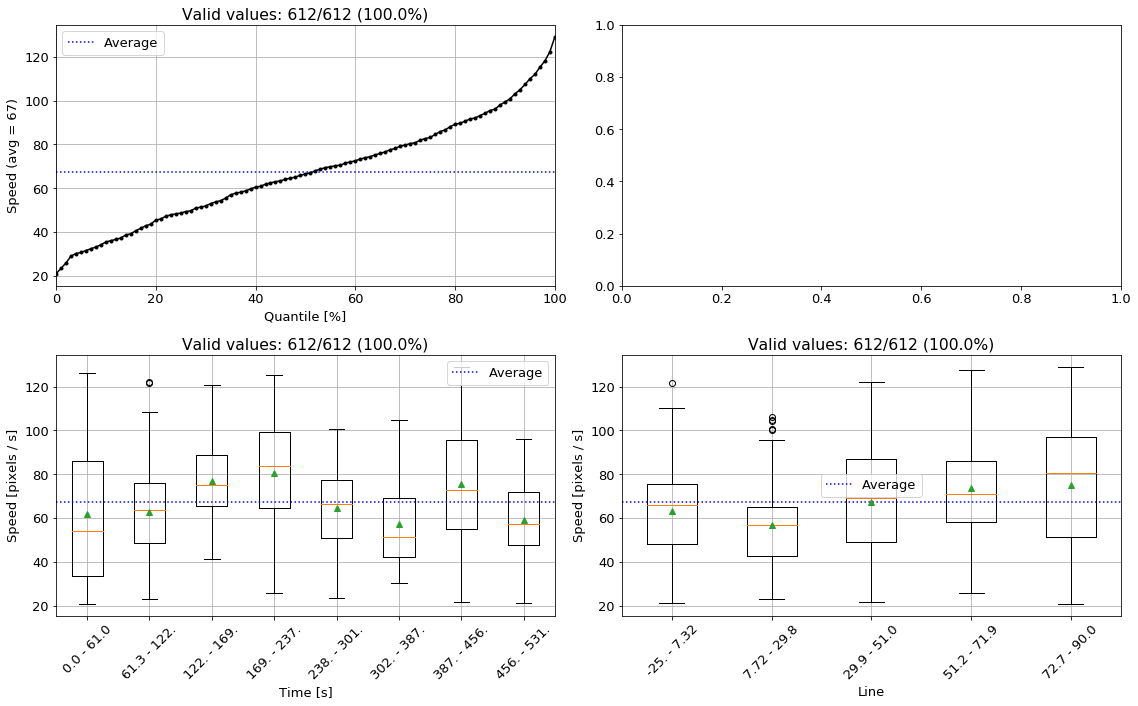

In [29]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)

print(f'Valid tracks:\t{ids.sum()}/{len(ids)} ({100*ids.mean():.0f}%)')

_, axs = plt.subplots(2,2, figsize=(16,10))
tt.qplot(df.v[ids], ylab=f'Speed (avg = {df.v[ids].mean():.0f})', ax=axs[0,0])
tt.boxplot_per_bucket(df.t0[ids], df.v[ids], n_buckets=8, xlab='Time [s]', ylab='Speed [pixels / s]', ax=axs[1,0])
tt.boxplot_per_bucket(df.road_perpendicularity[ids], df.v[ids], xlab='Line', ylab='Speed [pixels / s]', ax=axs[1,1])
plt.tight_layout()

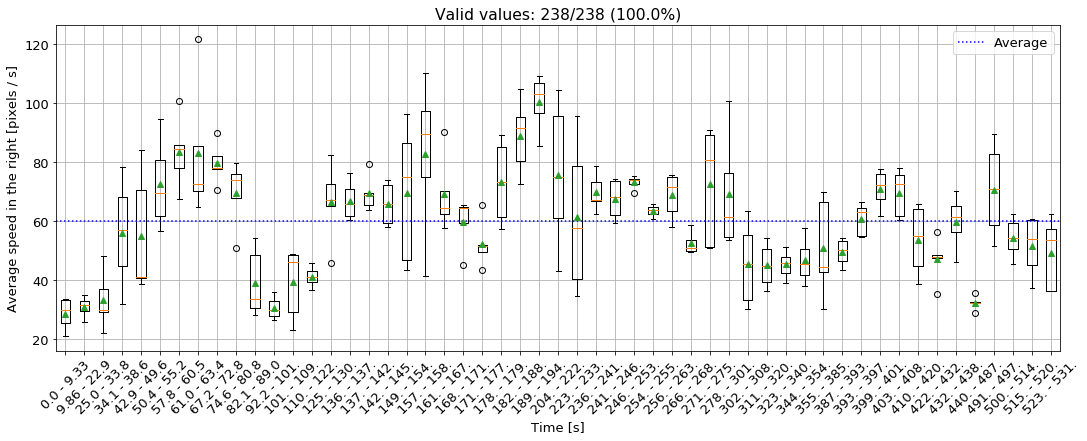

In [30]:
ids = df.loc[:,['consistent_class','consistent_xy_nas','valid_x_dir','valid_y_dir',
                'valid_size','long_path']].all(axis=1)
ids = np.logical_and(ids, df.road_perpendicularity<29)

plt.figure(figsize=(18,6))
tt.boxplot_per_bucket(df.t0[ids], df.v[ids], n_buckets=530//10, xlab='Time [s]', ylab='Average speed in the right [pixels / s]')

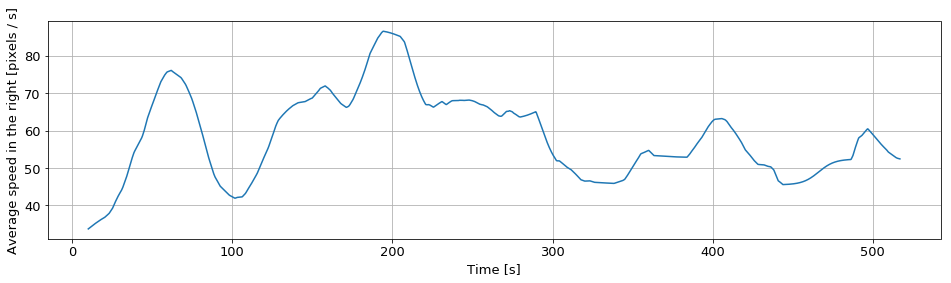

In [31]:
times = list(np.arange(10, df.t0.max()-20, 1/FPS))
decay = 10 # 1/e factor every "decay" seconds
ws = [np.exp(-np.abs(df[ids].t0-t)/decay) for t in times]
rolling_speed = [np.sum(w*df[ids].v)/np.sum(w) for w in ws]

_, axs = plt.subplots(1,1,figsize=(16,4))
ax = axs
ax.plot(times, rolling_speed)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Average speed in the right [pixels / s]')
ax.grid()

Conclusions:
- Speed varies between lines. In particular, the rightest line is very slow.
- Speed varies a lot over time, without any clear periodicity.

**TODO**
- save some interesting videos and screenshots
- improve tracking (see readme)